In [2]:
import numpy as np
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.stats import kurtosis, skew, entropy

In [3]:
fs = 100
sampling_rate = 100
duration = 10

data_train = np.load('../Data/simu_20000_0.1_90_140_train.npy')
data_test = np.load('../Data/simu_10000_0.1_141_178_test.npy')
signals_train, S_train, D_train = data_train[:, :1000], data_train[:, -2], data_train[:, -1]
signals_test, S_test, D_test = data_test[:, :1000], data_test[:, -2], data_test[:, -1]


print(signals_test.shape, S_train.shape, D_test[0])
D_test, S_test


(10000, 1000) (20000,) 83.0


(array([83., 79., 73., ..., 88., 87., 69.]),
 array([172., 173., 146., ..., 155., 159., 164.]))

In [4]:
def standize(data):
    return (data - np.mean(data)) / np.std(data)

In [5]:
def update_array(a, data_tmp):
    i = 0
    while i < len(a) - 2:
        if data_tmp[a[i]] < data_tmp[a[i + 1]] < data_tmp[a[i + 2]]:
            a = np.delete(a, i)
        elif data_tmp[a[i]] > data_tmp[a[i + 1]] > data_tmp[a[i + 2]]:
            a = np.delete(a, i + 2)
        else:
            i += 1
    return a

def get_peaks(data_tmp, duration, sampling_rate):
    max = np.max(data_tmp)
    data_tmp = data_tmp / max

    t = np.linspace(0, duration, duration * sampling_rate)
    signal = data_tmp

    peak_indices, _ = find_peaks(signal) 

    t_peaks = t[peak_indices] 
    peak_values = signal[peak_indices]  
    interpolation_func = interp1d(t_peaks, peak_values, kind='linear', bounds_error=False, fill_value=0)
    envelope = interpolation_func(t)

    peaks2, _ = find_peaks(envelope, distance=10)

    peaks2 = update_array(peaks2, data_tmp)
    if len(peaks2) % 2 != 0:
        peaks2 = np.delete(peaks2, len(peaks2) - 1)

    return peaks2

In [6]:


def calculate_entropy(signal):
    prob_distribution = np.histogram(signal, bins=10, density=True)[0]
    ent = entropy(prob_distribution)
    return ent


def calculate_centroid(signal):
    centroid = np.sum(np.arange(len(signal)) * np.abs(signal)) / np.sum(np.abs(signal))
    return centroid

def calculate_spectral_entropy(signal, fs):
    f, Pxx = welch(signal, fs=fs)
    prob_distribution = Pxx / np.sum(Pxx)
    spec_entropy = entropy(prob_distribution)
    return spec_entropy


def calculate_spectral_centroid(signal, fs):
    f, Pxx = welch(signal, fs=fs)
    spectral_centroid = np.sum(f * Pxx) / np.sum(Pxx)
    return spectral_centroid


# # Calculate Spectral Maximum Peaks
# def calculate_spectral_max_peaks(signal, fs):
#     f, Pxx = welch(signal, fs=fs)
#     peaks, _ = find_peaks(Pxx)
#     max_peaks = f[peaks]
#     return max_peaks


# Calculate Power Bandwidth
def calculate_power_bandwidth(signal, fs):
    f, Pxx = welch(signal, fs=fs)
    total_power = np.sum(Pxx)
    power_bandwidth = np.sum(Pxx >= total_power / 2)
    return power_bandwidth


def get_features(signal, peaks, fs):
    """
    1. standize:
    2. features:
    """
    signal = standize(signal)
    large_peaks_arr, small_peaks_arr = peaks[0::2], peaks[1::2]
    large_amp_arr, small_amp_arr = signal[large_peaks_arr], signal[small_peaks_arr]
    
    large_amp, small_amp = np.mean(large_amp_arr), np.mean(small_amp_arr)
    large_minus_small_amp = large_amp - small_amp
    large_divide_by_small_amp = large_amp / small_amp

    features_amp_list = [large_amp, small_amp, large_minus_small_amp, large_divide_by_small_amp]
    
    large2small_dis_arr = small_peaks_arr - large_peaks_arr
    small2large_dis_arr = large_peaks_arr[1:] - small_peaks_arr[:-1]
    
    # print(large_peaks_arr)
    # print(small_peaks_arr)
    # print(large_peaks_arr[1:])
    # print(small_peaks_arr[-1:])

    large2large_dis_arr = np.diff(large_peaks_arr)

    large2small_dis = np.mean(large2small_dis_arr)
    small2large_dis = np.mean(small2large_dis_arr)
    large2large_dis = np.mean(large2large_dis_arr)
    large2small_divide_by_small2large_dis = large2small_dis / small2large_dis

    features_dis_list = [large2small_dis, small2large_dis, large2large_dis,  large2small_divide_by_small2large_dis]

    # # spectrum
    # spec_entropy = calculate_spectral_entropy(signal, fs)
    # spec_centroid = calculate_spectral_centroid(signal, fs)
    # power_bandwidth = calculate_power_bandwidth(signal, fs)

    # features_spec_list = [spec_entropy, spec_centroid, power_bandwidth]

    # # others
    # maximum = np.max(signal)
    # minimum = np.min(signal)

    # mean_abs_difference = np.mean(np.abs(np.diff(signal)))
    # mean_difference = np.mean(np.diff(signal))
    # sum_abs_difference = np.sum(np.abs(np.diff(signal)))
    
    # rms = np.sqrt(np.mean(np.square(signal)))
    # entropy = calculate_entropy(signal)
    # centroid = calculate_centroid(signal)
    # kurt = kurtosis(signal)
    # skeww = skew(signal)

    # zero_crossing_rate = len(signal[signal > 0]) / len(signal)
    # # energy = np.sum(signal ** 2)

    # features_other_list = [maximum, minimum, mean_abs_difference, mean_difference, sum_abs_difference,
    #                     rms, entropy, centroid, kurt, skeww,zero_crossing_rate]

    # features_list = features_amp_list + features_dis_list + features_spec_list + features_other_list
    features_list = features_amp_list + features_dis_list

    return np.array(features_list) 


# signal = signals_train[0]
# peaks = get_peaks(signal, duration, sampling_rate)
# features = get_features(signal, peaks, fs)
# features.shape


# features_train, features_test = [], []

# for signal in signals_train:
#     peaks = get_peaks(signal, duration, sampling_rate)
#     features = get_features(signal, peaks, fs)
#     features_train.append(features)



# for signal in signals_test:
#     peaks = get_peaks(signal, duration, sampling_rate)
#     features = get_features(signal, peaks, fs)
#     features_test.append(features)

# features_train = np.array(features_train)
# features_test = np.array(features_test)

# features_train.shape, features_test.shape

In [7]:
# np.save('../Data/features_train_23.npy', features_train)
# np.save('../Data/features_test_23.npy', features_test)
# features_train = np.load('../Data/features_train_23.npy')
# features_test = np.load('../Data/features_test_23.npy')


# np.save('../Data/features_train_8.npy', features_train)
# np.save('../Data/features_test_8.npy', features_test)

# features_train = np.load('../Data/features_train_8.npy')
# features_test = np.load('../Data/features_test_8.npy')


In [9]:

def delete_unique(a):
    mean = np.mean(a)
    std = np.std(a)
    # 设置阈值
    threshold = 1
    # 使用布尔索引删除特殊值
    filtered_a = a[np.abs(a - mean) <= threshold * std]
    return filtered_a

def get_mag_0(peaks2, data_tmp):
    return np.mean(data_tmp[peaks2[::2]])

def get_mag_1(peaks2, data_tmp):
    return np.mean(data_tmp[peaks2[1::2]])

def get_features(data_tmp, peaks2):
    max = np.max(data_tmp)
    min = np.min(data_tmp)
    data_tmp_raw = data_tmp
    data_tmp = data_tmp / max

    fs = 100

    data_tmp = data_tmp_raw / max

    diff_12 = peaks2[1::2] - peaks2[0::2]
    diff_21 = peaks2[2::2] - peaks2[1:-1:2]
    diff_22 = peaks2[2::2] - peaks2[:-2:2]

    diff_12 = delete_unique(diff_12)
    diff_21 = delete_unique(diff_21)
    diff_22 = delete_unique(diff_22)

    m_12 = np.mean(diff_12)
    m_21 = np.mean(diff_21)
    m_22 = np.mean(diff_22)

    mag_0 = get_mag_0(peaks2, data_tmp_raw)
    mag_1 = get_mag_1(peaks2, data_tmp_raw)

    diff_12_mean = np.mean(diff_12)
    diff_21_mean = np.mean(diff_21)

    if diff_12_mean < diff_21_mean:
        diff_min = diff_12_mean
    else:
        diff_min = diff_21_mean

    diff_min = int(diff_min / 2)

    kurt = []
    for i in range(1, len(peaks2) - 1):
        seg = data_tmp[peaks2[i] - diff_min:peaks2[i] + diff_min]
        if len(seg) > 0:
            kurt.append(kurtosis(seg))

    kurt2 = kurt[::2]
    kurt1 = kurt[1::2]

    kurt2_mean = np.mean(kurt2)
    kurt1_mean = np.mean(kurt1)

    sk = []
    for i in range(1, len(peaks2) - 1):
        seg = data_tmp[peaks2[i] - diff_min:peaks2[i] + diff_min]
        if len(seg) > 0:
            sk.append(skew(seg))

    skew2 = sk[::2]
    skew1 = sk[1::2]

    skew2_mean = np.mean(skew2)
    skew1_mean = np.mean(skew1)

    features = np.array([m_12, m_21, m_22, mag_0, mag_1, mag_0 / mag_1, kurt2_mean, kurt1_mean, skew1_mean, skew2_mean])

    return features


# features_train, features_test = [], []

# for signal in signals_train:
#     peaks = get_peaks(signal, duration, sampling_rate)
#     features = get_features(signal, peaks)
#     features_train.append(features)



# for signal in signals_test:
#     peaks = get_peaks(signal, duration, sampling_rate)
#     features = get_features(signal, peaks)
#     features_test.append(features)

# features_train = np.array(features_train)
# features_test = np.array(features_test)

# np.save('../Data/features_train_10.npy', features_train)
# np.save('../Data/features_test_10.npy', features_test)

features_train = np.load('../Data/features_train_10.npy')
features_test = np.load('../Data/features_test_10.npy')


In [27]:
D12D21 = features_train[:, 0] / features_train[:, 1]

C:\Users\86189\AppData\Local\Temp\ipykernel_8512\1710588305.py:1: RuntimeWarning: divide by zero encountered in true_divide
  features_train[:, 0] / features_train[:, 1]


array([1.69077397, 1.52926183, 0.45823817, ..., 1.88976928, 1.12906631,
       1.11317292])

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


C:\Users\86189\AppData\Local\Temp\ipykernel_8512\3917738460.py:10: RuntimeWarning: divide by zero encountered in true_divide
  p1 = np.corrcoef(features_train[:, i], features_train[:, 0] / features_train[:, 1])[0, 1]
d:\ANACONDA\envs\pytorch\lib\site-packages\numpy\lib\function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


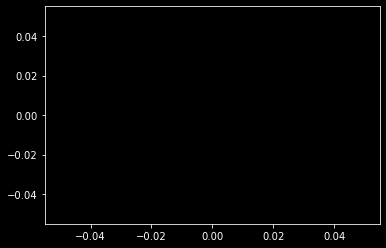

In [28]:
features_train[0], S_train[0]


# import numpy as np
# import matplotlib.pyplot as plt
p1s = []
p2s = []
for i in range(len(features_train[0])):
    # print(i)
    p1 = np.corrcoef(features_train[:, i], features_train[:, 0] / features_train[:, 1])[0, 1]
    print(p1)
    p1s.append(p1)
    # p2 = np.corrcoef(features_train[:, i], D_train)[0, 1]
    # p2s.append(p2)
    # print(p1, p2)
plt.plot(p1s)
# 计算皮尔逊相关系数
# correlation_coefficient = np.corrcoef(features_train[:, 1], S_train)[0, 1]

# 绘制散点图
# plt.scatter(, y, label=f"Pearson's r = {correlation_coefficient:.2f}")
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.title('Scatter Plot with Pearson Correlation')
# plt.legend()
# plt.show()


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

BATCH_SIZE = 32

input_size = 10

scaler = MinMaxScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

features_train_ft = torch.FloatTensor(features_train[:, :input_size])
features_test_ft = torch.FloatTensor(features_test[:, :input_size])

S_train_ft = torch.FloatTensor(S_train)
S_test_ft = torch.FloatTensor(S_test)
D_train_ft = torch.FloatTensor(D_train)
D_test_ft = torch.FloatTensor(D_test)

train_dataset_S = TensorDataset(features_train_ft, S_train_ft)
train_dataset_D = TensorDataset(features_train_ft, D_train_ft)
test_dataset_S = TensorDataset(features_test_ft, S_test_ft)
test_dataset_D = TensorDataset(features_test_ft, D_test_ft)

train_dataset = train_dataset_S
test_dataset = test_dataset_S

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE)

class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(SimpleMLP, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden_size1)
        self.hidden2 = nn.Linear(hidden_size1, hidden_size1)
        self.hidden3 = nn.Linear(hidden_size1, hidden_size1)
        self.hidden4 = nn.Linear(hidden_size1, hidden_size1)
        self.hidden5 = nn.Linear(hidden_size1, hidden_size2)
        self.output = nn.Linear(hidden_size2, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.hidden1(x))
        x = self.sigmoid(self.hidden2(x))
        x = self.sigmoid(self.hidden3(x))
        x = self.hidden4(x)
        x = self.hidden5(x)
        x = self.output(x)
        return x


# input_size = 23
hidden_size1 = input_size 
hidden_size2 = input_size // 2
output_size = 1


model = SimpleMLP(input_size, hidden_size1, hidden_size2, output_size)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 1000

for epoch in range(num_epochs):
    losses = []
    for data, label in train_loader:
        outputs = model(data)
        loss = criterion(outputs, label)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()    

    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(losses):.4f}')

# with torch.no_grad():
    # predictions = model(x_test)

# print("Predictions:", predictions)


d:\ANACONDA\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:96: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch [5/1000], Loss: 12.7666
Epoch [10/1000], Loss: 12.7700
Epoch [15/1000], Loss: 12.7644
Epoch [20/1000], Loss: 12.7722
Epoch [25/1000], Loss: 12.7744
Epoch [30/1000], Loss: 12.7747
Epoch [35/1000], Loss: 12.7638
Epoch [40/1000], Loss: 12.7624
Epoch [45/1000], Loss: 12.7723
Epoch [50/1000], Loss: 12.7763
Epoch [55/1000], Loss: 12.7797
Epoch [60/1000], Loss: 12.7660
Epoch [65/1000], Loss: 12.7676
Epoch [70/1000], Loss: 12.7772
Epoch [75/1000], Loss: 12.7706
Epoch [80/1000], Loss: 12.7708
Epoch [85/1000], Loss: 12.7705
Epoch [90/1000], Loss: 12.7720
Epoch [95/1000], Loss: 12.7782
Epoch [100/1000], Loss: 12.7672
Epoch [105/1000], Loss: 12.7756
Epoch [110/1000], Loss: 12.7593
Epoch [115/1000], Loss: 12.7615
Epoch [120/1000], Loss: 12.7649
Epoch [125/1000], Loss: 12.7657
Epoch [130/1000], Loss: 12.7673
Epoch [135/1000], Loss: 12.7706
Epoch [140/1000], Loss: 12.7670
Epoch [145/1000], Loss: 12.7704
Epoch [150/1000], Loss: 12.7624
Epoch [155/1000], Loss: 12.7710
Epoch [160/1000], Loss: 12.7

KeyboardInterrupt: 